<a href="https://colab.research.google.com/github/fspanda/FPL-Fantasy-Premier-league-Forecasting/blob/main/Code/Fantasy_League_AK_player.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/vaastav/Fantasy-Premier-League.git
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

Cloning into 'Fantasy-Premier-League'...
remote: Enumerating objects: 5982, done.
remote: Counting objects: 100% (5982/5982), done.
remote: Compressing objects: 100% (3150/3150), done.
remote: Total 119401 (delta 2456), reused 5289 (delta 2329), pack-reused 113419
Receiving objects: 100% (119401/119401), 39.61 MiB | 22.83 MiB/s, done.
Resolving deltas: 100% (55602/55602), done.


In [ ]:
import os

file_list = os.listdir('/content/Fantasy-Premier-League/data/2019-20/players')
file_list

In [169]:
first = True
for name in file_list:
  file=pd.read_csv("/content/Fantasy-Premier-League/data/2019-20/players/{}/gw.csv".format(name))
  file_length=len(file)
  tmp_X=file.drop('total_points',axis=1)

  tmp_Y=file[['total_points']]
  tmp_Y=tmp_Y.drop(0,axis=0)  
  tmp_X=tmp_X.drop(file_length-1,axis=0)
  tmp_X=tmp_X.drop("kickoff_time",axis=1)
  if first:
    first=False
    train_X=tmp_X
    train_Y=tmp_Y
  train_X=pd.concat([train_X,tmp_X])
  train_Y=pd.concat([train_Y,tmp_Y])




In [170]:
train_X_t=train_X.values
train_Y_t=train_Y.values
train_X_t=train_X_t.astype(float)
train_Y_t=train_Y.astype(float)

In [171]:
train_X.shape

(21873, 29)

In [151]:
from keras import models
from keras import layers
def build_model():
    model = Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_X_t.shape[1],1)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [152]:
model=build_model()
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 29, 64)            128       
_________________________________________________________________
dense_27 (Dense)             (None, 29, 64)            4160      
_________________________________________________________________
dense_28 (Dense)             (None, 29, 1)             65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [186]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_X_t, train_Y_t, test_size=0.1) 

In [187]:
import autokeras as ak

input_node = ak.StructuredDataInput()
output_node = ak.CategoricalToNumerical()(input_node)
output_node = ak.DenseBlock()(output_node)
output_node = ak.RegressionHead()(output_node)
reg = ak.AutoModel(inputs=input_node, outputs=output_node, max_trials=30,
                   overwrite=True)
reg.fit(x_train, y_train, epochs=10)


Trial 30 Complete [00h 00m 52s]
val_loss: 4.279174327850342

Best val_loss So Far: 4.217753887176514
Total elapsed time: 00h 25m 32s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
616/616 [==============================] - 6s 7ms/step - loss: 9.0059 - mean_squared_error: 9.0059
Epoch 2/10
616/616 [==============================] - 4s 7ms/step - loss: 5.3760 - mean_squared_error: 5.3760
Epoch 3/10
616/616 [==============================] - 4s 7ms/step - loss: 5.3036 - mean_squared_error: 5.3036
Epoch 4/10
616/616 [==============================] - 5s 7ms/step - loss: 5.2561 - mean_squared_error: 5.2561
Epoch 5/10
616/616 [==============================] - 5s 8ms/step - loss: 5.2309 - mean_squared_error: 5.2309
Epoch 6/10
616/616 [==============================] - 5s 7ms/step - loss: 5.2080 - mean_squared_error: 5.2080
Epoch 7/10
616/616 [==============================] - 5s 7ms/step - loss: 5.1853 - mean_squared_error: 5.1853
Epoch 8/10
616/616 [==============================] - 4s 7m

In [188]:
model = reg.export_model()
model.summary()
# numpy array in object (mixed type) is not supported.
# you need convert it to unicode or float first.
model.predict(x_test)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 29)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                960       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128   

array([[0.94813   ],
       [0.8191149 ],
       [0.95091987],
       ...,
       [0.7563399 ],
       [0.8143859 ],
       [0.72705746]], dtype=float32)

In [189]:
predict=model.predict(x_test)
y_test=y_test.reset_index(drop=True)

In [233]:
x=y_test[(y_test["total_points"]>5.0)].index.tolist()

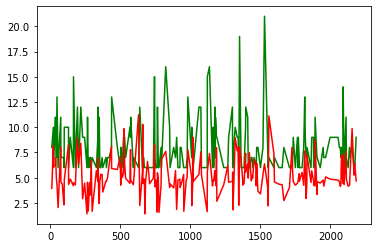

In [234]:

from matplotlib import pyplot as plt
#x=list(range(len(train_Y_t)))
st=0
num=200
#x=list(range(st,num))
plt.plot(x,y_test[(y_test["total_points"]>5.0)],color="green")
plt.plot(x,predict[x]*2,color="red")
plt.show()



In [235]:
model.evaluate(x_test,y_test)

69/69 [==============================] - 0s 5ms/step - loss: 4.7895 - mean_squared_error: 4.7895


[4.789466857910156, 4.789466857910156]